In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB

# Identifying perturbations

Given transcript counts for a gene in a number of cells we can estimate bounds on the parameters of the reaction network. Assuming the counts are sampled from the stationary distribution of the system we bootstrap to produce CI bounds on the distribution, then optimize over constraints constructed from these values and the reaction system.

## Bootstrap

In [2]:
def bootstrap(samples, N, plot=False, printing=False, drop_missing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    samples: sample from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's
    drop_missing: whether to drop missing values from the sample,
        or replace them with 0 (as used when preparing BayNorm data)

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """

    '''pre-processing for real data'''
    # change to series
    # samples = pd.Series(samples)

    # drop missing values
    #if drop_missing:
    #    samples = samples.dropna()
    # replace with 0
    #else:
    #    samples = samples.fillna(value=0.0)

    # change to int
    #samples = samples.astype('int64')

    # maximum state observed
    x_max = int(np.nanmax(samples))
    # size of sample
    n = len(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    if printing or plot:
        for x in range(x_max + 1):
            if printing:
                print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
            if plot:
                plt.hist(counts[:, x] / n)
                plt.title(f"Hist of p({x})")
                plt.axvline(intervals[x][0], color="red")
                plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

## Optimization

In [29]:
def optimization_NLP(params, N, intervals, K=100, frechet_bounds=False, print_solution=True, printing=False):
    """
    Solve Non-Linear Programming problem to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    K: upper bound on params (k's) for computational reasons
    frechet_bounds: bool to include additionally derived 'frechet' constraints
    print_solution: bool to print solution bounds
    printing: bool to print optimizer information
    """
	
	# number of marginals used
    M = int(N/2 + 1)

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # bounds from CI, on marginal
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds
    pl = np.array(pl)[:M]
    pu = np.array(pu)[:M]

    # form doubled bounds
    pdl = np.repeat(pl,2)
    pdu = np.repeat(pu,2)
	
    # marginal = A @ p
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

    # create model
    m = gp.Model("gene_exp")

    # set options
    if not printing:
        m.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = m.addMVar(shape=N + 2, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if params[0] == "v":
        k_on = m.addVar(vtype=GRB.CONTINUOUS, name="k_on", lb=0, ub=K)
    else:
        k_on = params[0]
    if params[1] == "v":
        k_off = m.addVar(vtype=GRB.CONTINUOUS, name="k_off", lb=0, ub=K)
    else:
        k_off = params[1]
    if params[2] == "v":
        k_tx = m.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
    else:
        k_tx = params[2]
    if params[3] == "v":
        k_deg = m.addVar(vtype=GRB.CONTINUOUS, name="k_deg", lb=0, ub=K)
    else:
        k_deg = params[3]

    # Constraints:
    # Stationary condition: Qp = 0
    m.addConstr(k_on*(Q_on @ p) + k_off*(Q_off @ p) + k_tx*(Q_tx @ p) + k_deg*(Q_deg @ p) == 0, name="Qp=0")
    # marginal bounds: p_L <= A @ p <= p_U
    m.addConstr(pl <= A @ p, name="Marginal lb")
    m.addConstr(A @ p <= pu, name="Marginal ub" )
    # truncated joint dist: sum(p) <= 1
    m.addConstr(p.sum() <= 1, name="Joint dist")

    if frechet_bounds:
        # frechet bound vector
        kv_off = np.array([0 if x % 2 else 1 for x in range(N + 2)])
        kv_on = np.array([1 if x % 2 else 0 for x in range(N + 2)])
        kv = k_off * kv_off + k_on * kv_on
        # frechet bound
        m.addConstr((k_on + k_off) * p <= kv)

    # solution dict
    solution = {}

    par_names = ["k_on", "k_off", "k_tx", "k_deg"]

    # optimize for each unknown parameter
    for i, par in enumerate([k_on, k_off, k_tx, k_deg]):

        # param name
        name = par_names[i]

        # if unknown: optimize
        if params[i] == "v":

            # set objective
            m.setObjective(par, GRB.MINIMIZE)

            try:
                # optimize (solve)
                m.optimize()
                # record
                min_val = m.ObjVal
            except:
                # record as infeasible/unbounded
                min_val = None

            # reset
            m.reset()

            # change objective
            m.setObjective(par, GRB.MAXIMIZE)

            try:
                # re-optimize (re-solve)
                m.optimize()
                # record
                max_val = m.ObjVal
            except:
                # record as infeasible/unbounded
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # if known: store
        else:
            solution[name] = par
    
    # print
    if print_solution:
        for key, val in solution.items():
            if type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            else:
                print(f"{key} = {val}")

    return solution

## Example

In [34]:
# original
counts_original = pd.read_csv("Simulated_data/counts_original.csv", index_col="Unnamed: 0")
parameters_original = pd.read_csv("Simulated_data/parameters_original.csv", index_col="Unnamed: 0")
# perturbed
counts_perturbed = pd.read_csv("Simulated_data/counts_perturbed.csv", index_col="Unnamed: 0")
parameters_perturbed = pd.read_csv("Simulated_data/parameters_perturbed.csv", index_col="Unnamed: 0")

In [104]:
intervals_original = bootstrap(counts_original.loc["gene_4"], 1000, printing=True)
print("\n")
intervals_perturbed = bootstrap(counts_perturbed.loc["gene_4"], 1000, printing=True)

95% CI for p(0) is: (0.0222, 0.0314)
95% CI for p(1) is: (0.078, 0.09300499999999999)
95% CI for p(2) is: (0.1306, 0.15)
95% CI for p(3) is: (0.155, 0.175205)
95% CI for p(4) is: (0.1504, 0.171)
95% CI for p(5) is: (0.1296, 0.14960500000000002)
95% CI for p(6) is: (0.0884, 0.1046)
95% CI for p(7) is: (0.0676, 0.082605)
95% CI for p(8) is: (0.045595000000000004, 0.0572)
95% CI for p(9) is: (0.020995000000000003, 0.029804999999999995)
95% CI for p(10) is: (0.0126, 0.019404999999999995)
95% CI for p(11) is: (0.0086, 0.0142)
95% CI for p(12) is: (0.0024, 0.0058)
95% CI for p(13) is: (0.0004, 0.0022)
95% CI for p(14) is: (0.0004, 0.0022)
95% CI for p(15) is: (0.0, 0.001)
95% CI for p(16) is: (0.0, 0.001)


95% CI for p(0) is: (0.002795, 0.0062)
95% CI for p(1) is: (0.017795000000000002, 0.0256)
95% CI for p(2) is: (0.0414, 0.0534)
95% CI for p(3) is: (0.0828, 0.0988)
95% CI for p(4) is: (0.0926, 0.109)
95% CI for p(5) is: (0.128595, 0.14680500000000002)
95% CI for p(6) is: (0.127395, 0.1466

In [117]:
solution_original = optimization_NLP_new(params=["v", "v", "v", 1.0], N=20, intervals=intervals_original, frechet_bounds=True)
print("\n")
solution_perturbed = optimization_NLP_new(params=["v", "v", "v", 1.0], N=10, intervals=intervals_perturbed, frechet_bounds=True)

k_on in (3.6254992372171158, 10.291587286356677)
k_off in (2.0891729329637982, 100.0)
k_tx in (6.709584384800729, 66.19982630404822)
k_deg = 1.0


k_on in (5.192322428668154, 37.53724754795519)
k_off in (1.5310446234699968, 100.0)
k_tx in (6.881439767987239, 96.26025945074466)
k_deg = 1.0


In [118]:
print(parameters_original.loc["gene_4"])
print("\n")
print(parameters_perturbed.loc["gene_4"])

k_on      8.225970
k_off    38.113865
k_tx     24.297643
k_deg     1.000000
Name: gene_4, dtype: float64


k_on     13.596697
k_off    38.113865
k_tx     24.297643
k_deg     1.000000
Name: gene_4, dtype: float64


## Plotting

In [133]:
def plot_intervals(solution_original, solution_perturbed, parameters_original, parameters_perturbed):

    # original results
    x_org = [1, 4, 7]
    y_org = [parameters_original['k_on'],
             parameters_original['k_off'],
             parameters_original['k_tx']]
    lbs_org = [abs(solution_original['k_on'][0] - parameters_original['k_on']),
               abs(solution_original['k_off'][0] - parameters_original['k_off']),
               abs(solution_original['k_tx'][0] - parameters_original['k_tx'])]
    ubs_org = [abs(solution_original['k_on'][1] - parameters_original['k_on']),
               abs(solution_original['k_off'][1] - parameters_original['k_off']),
               abs(solution_original['k_tx'][1] - parameters_original['k_tx'])]
    bounds_org = [lbs_org, ubs_org]

    # perturbed results
    x_pert = [2, 5, 8]
    y_pert = [parameters_perturbed['k_on'],
             parameters_perturbed['k_off'],
             parameters_perturbed['k_tx']]
    lbs_pert = [abs(solution_perturbed['k_on'][0] - parameters_perturbed['k_on']),
                abs(solution_perturbed['k_off'][0] - parameters_perturbed['k_off']),
                abs(solution_perturbed['k_tx'][0] - parameters_perturbed['k_tx'])]
    ubs_pert = [abs(solution_perturbed['k_on'][1] - parameters_perturbed['k_on']),
                abs(solution_perturbed['k_off'][1] - parameters_perturbed['k_off']),
                abs(solution_perturbed['k_tx'][1] - parameters_perturbed['k_tx'])]
    bounds_pert = [lbs_pert, ubs_pert]

    # plot
    plt.figure(figsize=(12, 8))
    plt.xticks([1.5, 4.5, 7.5], ['k_on', 'k_off', 'k_tx'])
    plt.errorbar(x_org, y_org, yerr=bounds_org, fmt='o', color = "red", ecolor = 'orange', capsize=5.0, label="Original")
    plt.errorbar(x_pert, y_pert, yerr=bounds_pert, fmt='o', color = "red", ecolor = 'blue', capsize=5.0, label="Perturbed")
    plt.xlabel("Parameters")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

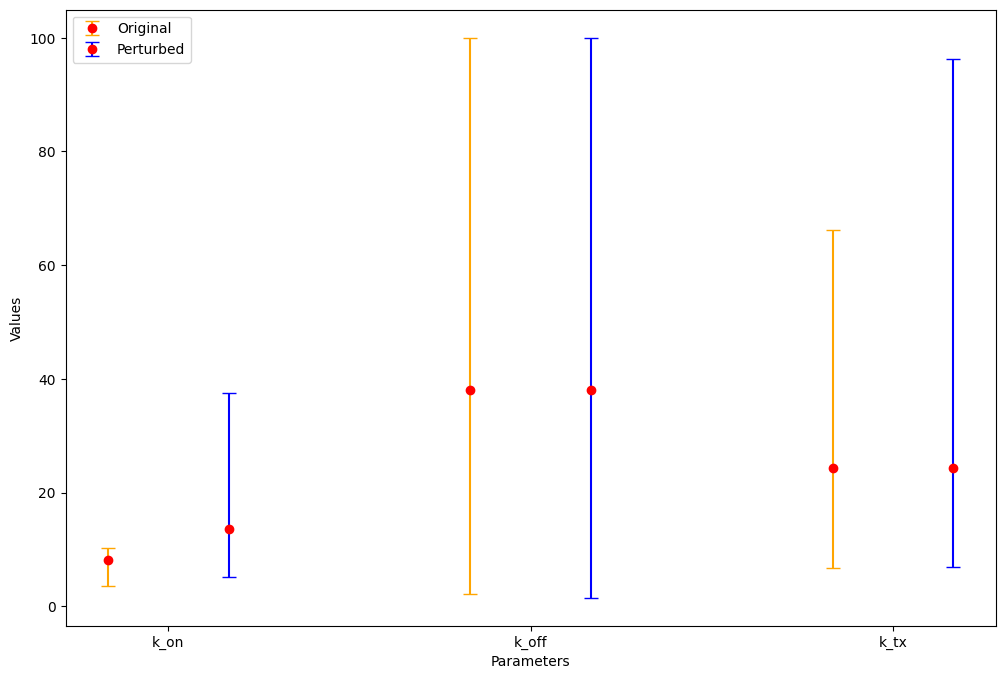

In [134]:
plot_intervals(solution_original, solution_perturbed, parameters_original.loc['gene_4'], parameters_perturbed.loc['gene_4'])

In [122]:
solution_perturbed

{'k_on': [5.192322428668154, 37.53724754795519],
 'k_off': [1.5310446234699968, 100.0],
 'k_tx': [6.881439767987239, 96.26025945074466],
 'k_deg': 1.0}